## CSEC-759 Final Project
### Advanced Malware Forensics - Professor Nate Mathews | Raina Freeman

This project is a replication study based on 'Comparison of Machine Learning Algorithms for Malware Detection Using EDGE-IIoTSET Dataset in IoT' by Alshehri et al.
DOI: [10.14569/IJACSA.2025.01601118](doi.org/10.14569/IJACSA.2025.01601118).

Data and preprocessing steps from the [Edge-IIoTSET dataset](https://www.kaggle.com/datasets/mohamedamineferrag/edgeiiotset-cyber-security-dataset-of-iot-iiot).


## Section I: Preprocessing

The first step includes reading in the CSV file, dropping unnecessary rows and columns, and shuffling the dataset to prepare it for use.

In [1]:
import pandas as pd
from sklearn.utils import shuffle

# import dataset into PANDAS dataframe
df = pd.read_csv('ML-EdgeIIoT-dataset.csv', low_memory=False)

# drop unnecessary columns
drop_columns = ["frame.time", "ip.src_host", "ip.dst_host", "arp.src.proto_ipv4","arp.dst.proto_ipv4", 
                "http.file_data","http.request.full_uri","icmp.transmit_timestamp", "http.request.uri.query", 
                "tcp.options","tcp.payload","tcp.srcport", "tcp.dstport", "udp.port", "mqtt.msg"]
df.drop(drop_columns, axis=1, inplace=True)

# drop rows with missing values
df.dropna(axis=0, how='any', inplace=True)

# drop duplicate rows
df.drop_duplicates(subset=None, keep='first', inplace=True)

# shuffle dataset
df = shuffle(df)

The next step includes encoding the categorical variables so they can be understood by the model.

The method used is dummy encoding, which creates a binary variable for each potential category.

In [2]:
import numpy as np

# define categorical columns
categorical_cols = ["http.request.method", "http.referer", "http.request.version", 
                     "dns.qry.name.len", "mqtt.conack.flags", "mqtt.protoname", "mqtt.topic"]

# dummy encoding
for col in categorical_cols:
    dummies = pd.get_dummies(df[col])
    for val in dummies.columns:
        dummy_name = f"{col}-{val}"
        df[dummy_name] = dummies[val]
    df.drop(col, axis=1, inplace=True)

Finally, we will export the preprocessed dataset as a CSV.

In [3]:
df.to_csv('preprocessed_ML.csv', encoding='utf-8')

Just for reference, we can check how many of each attack type the preprocessed dataset contains:

In [4]:
print(df['Attack_type'].value_counts())

Attack_type
Normal                   24101
DDoS_UDP                 14498
DDoS_ICMP                13096
DDoS_HTTP                10495
SQL_injection            10282
DDoS_TCP                 10247
Uploading                10214
Vulnerability_scanner    10062
Password                  9972
Backdoor                  9865
Ransomware                9689
XSS                       9543
Port_Scanning             8921
Fingerprinting             853
MITM                       358
Name: count, dtype: int64


## Section 2: Data Processing

If running from this point, we may want to load the dataset in from preprocessed_ML.csv. The below code block provides this functionality (remember to change the conditional):

In [5]:
# Toggle True to reload the CSV
if False:
    import pandas as pd
    df = pd.read_csv('preprocessed_ML.csv')

Now we can finish processing the data by splitting it into testing and training sets and applying SMOTE (Synthetic Minority Oversampling Technique) on the training set to make sure the classes are balanced.

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from collections import Counter

# Change RANDOM_STATE to None for randomized splits, integer for consistent results
RANDOM_STATE = 42
# Change BINARY to 1 for binary classification, 0 for multi-class
BINARY = 0

# Separate dataset variables and encode labels
# Use Attack_label for binary classifier, Attack_type for multi-classifier
label_encoder = LabelEncoder()
X = df.drop(['Attack_label', 'Attack_type'], axis=1)
if (BINARY):
    y = label_encoder.fit_transform(df['Attack_label'])
else:
    y = label_encoder.fit_transform(df['Attack_type'])

# Split dataset, 80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

# Check statistics - before
# label_encoder.inverse_transform just reassigns the labels, nicer to read
print("Pre-SMOTE dataset shape: %s" % Counter(label_encoder.inverse_transform(y_train)))

# SMOTE generates synthetic data to balance class distribution in the training dataset 
# Only using SMOTE on training set to avoid skewing results
smote = SMOTE(random_state=RANDOM_STATE)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Check statistics - after
print("Post-SMOTE dataset shape: %s" % Counter(label_encoder.inverse_transform(y_train)))

Pre-SMOTE dataset shape: Counter({'Normal': 19212, 'DDoS_UDP': 11566, 'DDoS_ICMP': 10566, 'DDoS_HTTP': 8336, 'DDoS_TCP': 8256, 'SQL_injection': 8246, 'Uploading': 8165, 'Vulnerability_scanner': 8106, 'Password': 8010, 'Backdoor': 7871, 'Ransomware': 7695, 'XSS': 7621, 'Port_Scanning': 7124, 'Fingerprinting': 693, 'MITM': 289})
Post-SMOTE dataset shape: Counter({'SQL_injection': 19212, 'Uploading': 19212, 'DDoS_ICMP': 19212, 'XSS': 19212, 'DDoS_TCP': 19212, 'Normal': 19212, 'DDoS_UDP': 19212, 'Backdoor': 19212, 'Password': 19212, 'DDoS_HTTP': 19212, 'Ransomware': 19212, 'Port_Scanning': 19212, 'Vulnerability_scanner': 19212, 'Fingerprinting': 19212, 'MITM': 19212})


## Section 3: Random Forest

In this section, we train and test the Random Forest classifier. Many parameters were tested here, and these were chosen for best overall accuracy. 

In [22]:
from sklearn.ensemble import RandomForestClassifier

# Initialize and train
random_forest = RandomForestClassifier(n_estimators=500, max_depth=30, min_samples_split=5, min_samples_leaf=2, class_weight='balanced', random_state=RANDOM_STATE)
random_forest.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', max_depth=30,
                       min_samples_leaf=2, min_samples_split=5,
                       n_estimators=500, random_state=42)

In [ ]:
# Test - get predictions and probability estimates
y_pred = random_forest.predict(X_test)
y_prob = random_forest.predict_proba(X_test)

The code block below generates a number of performance metrics like those used in the paper, including accuracy, precision, confusion matrices, and ROC curves.

Classification Report:
                       precision    recall  f1-score   support

             Backdoor       0.98      0.95      0.96      1994
            DDoS_HTTP       0.91      0.94      0.92      2159
            DDoS_ICMP       1.00      1.00      1.00      2530
             DDoS_TCP       1.00      1.00      1.00      1991
             DDoS_UDP       1.00      1.00      1.00      2932
       Fingerprinting       0.49      0.84      0.62       160
                 MITM       1.00      1.00      1.00        69
               Normal       1.00      1.00      1.00      4889
             Password       0.78      0.86      0.82      1962
        Port_Scanning       0.94      0.98      0.96      1797
           Ransomware       0.97      0.93      0.95      1994
        SQL_injection       0.89      0.79      0.84      2036
            Uploading       0.84      0.84      0.84      2049
Vulnerability_scanner       1.00      0.95      0.97      1956
                  XSS       0.9

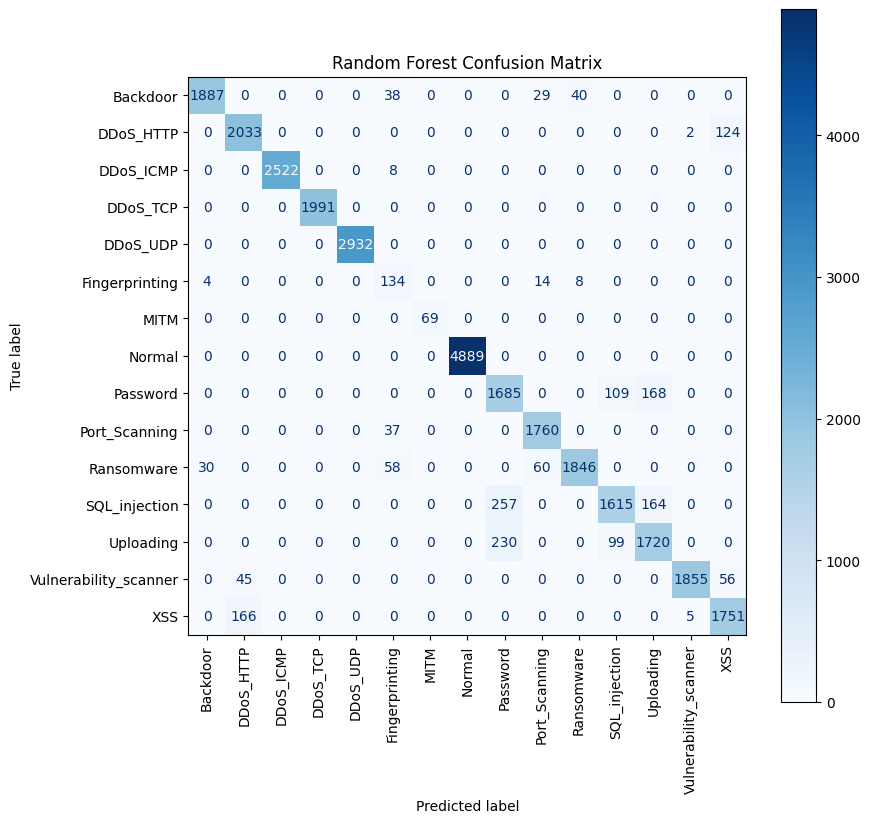

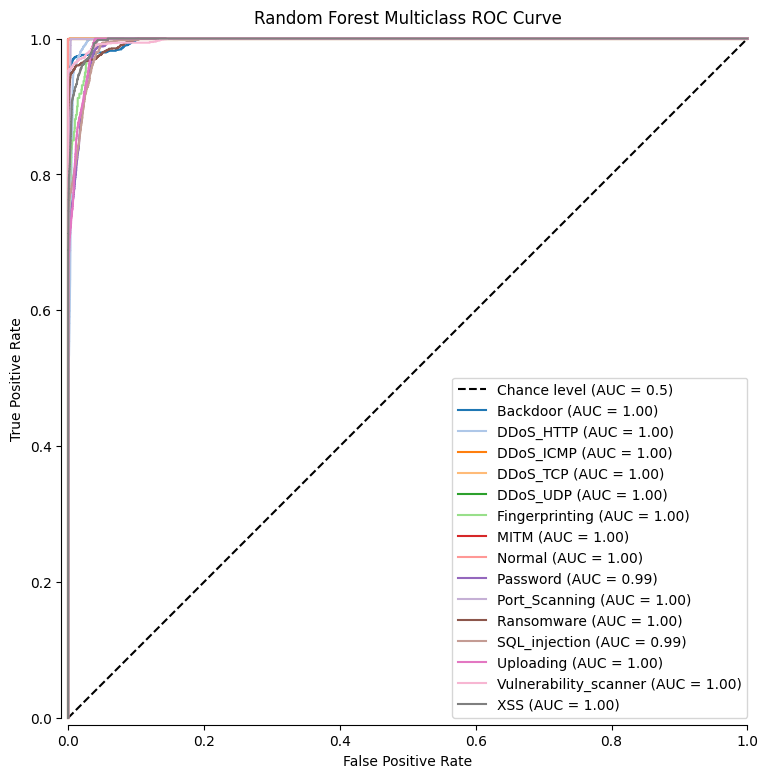

In [24]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, RocCurveDisplay

# Classification Report (includes accuracy and precision)
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


# Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=label_encoder.classes_)
fig, ax = plt.subplots(figsize=(9,9))
ax.set_title("Random Forest Confusion Matrix")
disp.plot(ax=ax, xticks_rotation="vertical", cmap=plt.cm.Blues)
plt.show()


# ROC Curve using one-versus-rest
fig, ax = plt.subplots(figsize=(9,9))

# binarize labels
label_binarizer = LabelBinarizer().fit(y_train)
y_test_bin = label_binarizer.transform(y_test)

# plan for colors
num_color = len(label_encoder.classes_)
cmap = plt.colormaps['tab20']

# Plot the chance level (diagonal) first
ax.plot([0, 1], [0, 1], linestyle="--", color="black", label="Chance level (AUC = 0.5)")

# get each ROC Curve
for class_id, c in enumerate(label_encoder.classes_):
    disp = RocCurveDisplay.from_predictions(
        y_test_bin[:, class_id],
        y_prob[:, class_id],
        name=f"{c}",
        color=cmap(class_id),
        ax=ax,
        despine=True
    )

# set axes and title
ax.set(xlabel="False Positive Rate", ylabel="True Positive Rate", title="Random Forest Multiclass ROC Curve")

plt.show()


We can also look at the feature importance. We will use the built-in feature importance for Random Forest.

In [25]:
importances = random_forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in random_forest.estimators_], axis=0)

forest_importances = pd.Series(importances, index=X_test.columns)
importances_std = pd.Series(std, index=X_test.columns)

forest_importances = forest_importances[forest_importances.abs() >= 0.001]

#from sklearn.inspection import permutation_importance

# Compute importances
#result = permutation_importance(random_forest, X_test, y_test, n_repeats=5, random_state=42)

# Get importances and std devs in PANDAS series
#forest_importances = pd.Series(result.importances_mean, index=X_test.columns)
#importances_std = pd.Series(result.importances_std, index=X_test.columns)


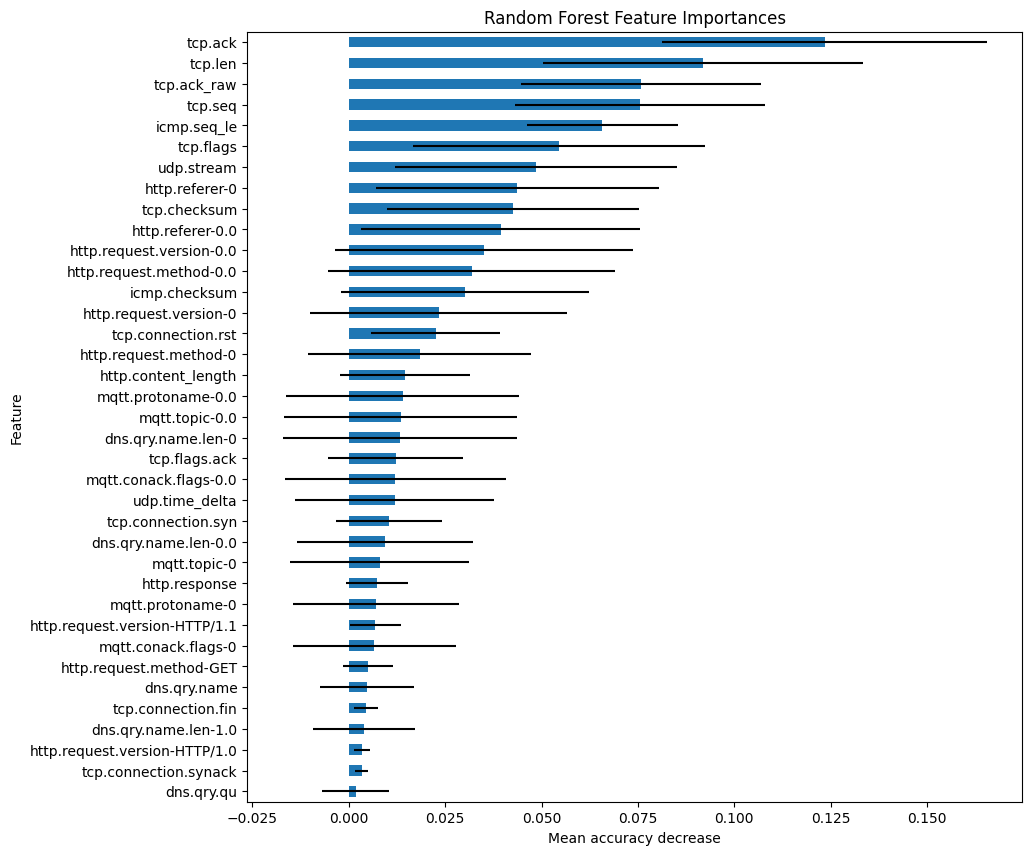

In [26]:
# Sort
plot_importances = forest_importances.sort_values(ascending=True)

# Refit standard deviations
plot_std = importances_std[plot_importances.index]

# Plot
fig, ax = plt.subplots(figsize=(10,10))
plot_importances.plot.barh(xerr=plot_std, ax=ax)
ax.set(title="Random Forest Feature Importances", xlabel="Mean accuracy decrease", ylabel="Feature")
plt.show()

In the full report, I will look into these features and analyze their importance.